# Sky Model

In [1]:
demFile = r"Great_Sand_Dunes.tif"
logoFile = "NACIS_gsd.tif"
skyConfig = r"..\SkyConfigFiles\Clear_400_NNW_45.txt"
#skyConfig = r"..\SkyConfigFiles\TESTING_12_NW_45.txt"
ve = 5
cellSize = 3.33

In [2]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from trf import utils, surface, shader, shadow

from ipywidgets import IntProgress, HTML, VBox
from IPython.display import display

cm=1/2.54

In [3]:
dem = np.asarray(Image.open(demFile))
d = np.copy(dem[120:3240,50:5250])
logo = np.asarray(Image.open(logoFile))
#dem[logo > 100] = dem.mean()
hi = d.max()

In [4]:
logo.shape

(3120, 5200)

In [5]:
d.shape

(3120, 5200)

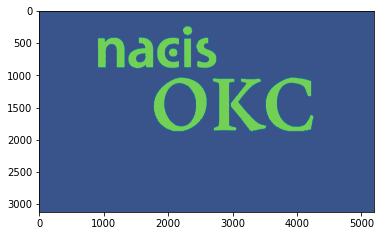

In [6]:
plt.imshow(logo)

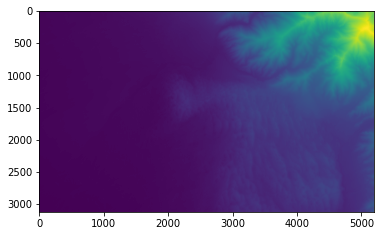

In [7]:
plt.imshow(d)

In [8]:
d[logo >= 150] += 50 #  dem.mean() # +  ( dem.max() - dem.mean())/2

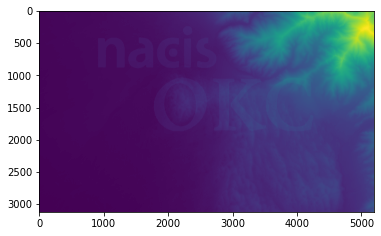

In [9]:
plt.imshow(d)

In [10]:
lights = utils.lightList(skyConfig)
snv = surface.normals_by_method(d, cellSize, "N82")
d = d * ve

progressMsg = HTML()
progressBar = IntProgress(min=0, max=len(lights))
vbox=VBox(children=[progressBar, progressMsg])
display(vbox)

In [11]:
accumulator = np.zeros(d.shape)
for (i, (azimuth, elev, wt)) in enumerate(lights):
    progressBar.value = i+1
    progressMsg.value = f"Light {progressBar.value} of {progressBar.max} : Az={azimuth} / El={elev} / Wt={wt}"
    shadowArray = shadow.shadowLine(d, float(azimuth), float(elev), cellSize)
    shadeArray = shader.lambert(snv, utils.lightVector(float(azimuth), float(elev)))
    shadeArray[shadeArray<0] = 0
    shadeArray[shadowArray>0] = 0
    accumulator = accumulator + (float(wt) * shadeArray)
progressBar.bar_style='success'

In [12]:
# stretch across min..max
hs = (accumulator - accumulator.min()) * (255 / (accumulator.max()-accumulator.min()))

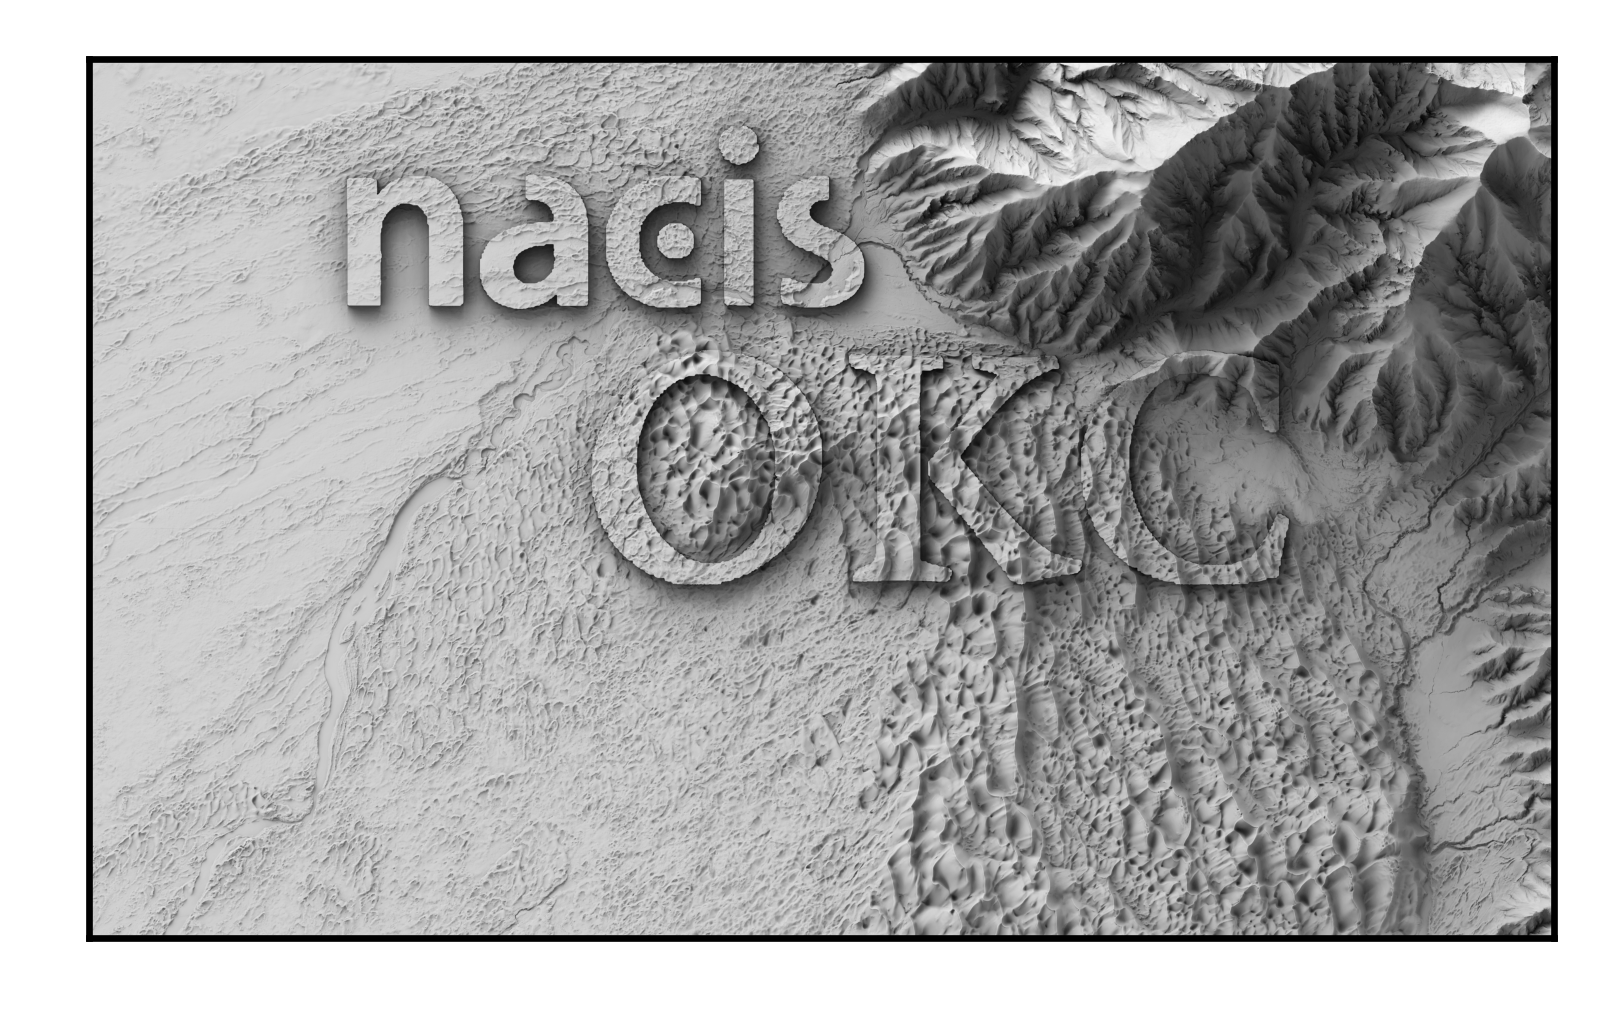

In [13]:
fig, axs = plt.subplots(1,1, figsize=(8*cm, 8*cm))
fig.set_dpi(600)
axs.yaxis.set_visible(False)
axs.xaxis.set_visible(False)
axs.imshow(accumulator, cmap='gray')
#axs.imshow(hs.astype('uint8'), cmap='gray', vmin=0, vmax=255)

In [14]:
x=Image.fromarray(hs.astype('uint8'))
x.save("GreatSandDunes_skymodel.jpg")